Import packages:

In [2]:
import pickle
import itertools
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import patsy
from sklearn import preprocessing, linear_model, model_selection, ensemble, metrics
from ggplot import *
from tqdm import tnrange, tqdm_notebook

/home/hobbs/.local/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/hobbs/.local/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/hobbs/.conda/envs/ipy3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now we need to import our data. I'm going to import it once from the csv, and create a pickle below. However, when I re-run this notebook I want to be able to skip steps, so I'll just load the pickle. That is much faster. The argument `quick=False` will force the program to re-create the pickle (for example if we change the csv data or add new variables to the load_data function).

In [3]:
def load_data(quick=True):
    
    def make_pickle():
        # Read csv
        df = pd.read_csv('nodes_final_data.csv')
        
        # Set the index
        df['time'] = pd.to_datetime(df['time'])
        df = df.set_index(['node', 'time'])

        # Create/ format some variables
        df['week'] = [value[1].isocalendar()[1] for value in df.index.values]

        # Save as a pickle
        df.to_pickle('nodes_final_data.p')
        
        return df
        
    if quick == True:
        try:
            print("Trying to open saved data.")
            with open('nodes_final_data.p', 'rb') as f:
                return pickle.load(f)
        
        except FileNotFoundError:
            print("No existing pickle found... picklemaking!")
            return make_pickle()
    else:
        print("Pickling a fresh new pickle.")
        return make_pickle()

def load_subset(n, df):
    print("Loading a subset with ", n, " nodes.")
    np.random.seed(seed=1)
    node_ids = df.index.get_level_values('node').unique()
    selected_nodes = list(np.random.choice(node_ids, size = n))
    return df.loc[selected_nodes]

In [7]:
df = load_subset(100, load_data())
df.head()

Trying to open saved data.
Loading a subset with  100  nodes.


year  month  date  hr  opr_hr  day  \
node         time                                                      
ALAMT4G_7_B1 2017-05-02 00:00:00  2017      5     1   0      18    2   
             2017-05-02 01:00:00  2017      5     1   1      19    2   
             2017-05-02 02:00:00  2017      5     1   2      20    2   
             2017-05-02 03:00:00  2017      5     1   3      21    2   
             2017-05-02 04:00:00  2017      5     1   4      22    2   

                                  dollar_mw      other_MW     solar_MW  \
node         time                                                        
ALAMT4G_7_B1 2017-05-02 00:00:00  30.549540  13091.870117  6837.720215   
             2017-05-02 01:00:00  47.267689  17182.660156  2931.449951   
             2017-05-02 02:00:00  71.159882  19997.630859   264.540009   
             2017-05-02 03:00:00  66.884888  19904.410156     0.000000   
             2017-05-02 04:00:00  48.442291  17607.289062     0.000000   

                                      wind_MW  load_MW  fuel_price  \
node         time                                                    
ALAMT4G_7_B1 2017-05-02 00:00:00  1992.119995  28981.0        2.83   
             2017-05-02 01:00:00  2254.040039  29669.0        2.83   
             2017-05-02 02:00:00  2461.199951  29458.0        2.83   
             2017-05-02 03:00:00  2499.290039  30325.0        2.83   
             2017-05-02 04:00:00  2473.360107  29429.0        2.83   

                                   net_exp_MW        temp       irrad  \
node         time                                                       
ALAMT4G_7_B1 2017-05-02 00:00:00 -8073.870117  292.096466  294.044172   
             2017-05-02 01:00:00 -8380.599609  292.121277  294.037069   
             2017-05-02 02:00:00 -8663.000000  292.146118  294.029965   
             2017-05-02 03:00:00 -8644.000000  292.170959  294.022861   
             2017-05-02 04:00:00 -8591.799805  292.195801  294.015758   

                                    wind_u    wind_v   latitude   longitude  \
node         time                                                             
ALAMT4G_7_B1 2017-05-02 00:00:00  2.531747  1.636286  33.765897 -118.103607   
             2017-05-02 01:00:00  2.531789  1.636183  33.765897 -118.103607   
             2017-05-02 02:00:00  2.531830  1.636081  33.765897 -118.103607   
             2017-05-02 03:00:00  2.531872  1.635978  33.765897 -118.103607   
             2017-05-02 04:00:00  2.531913  1.635875  33.765897 -118.103607   

                                  week  
node         time                       
ALAMT4G_7_B1 2017-05-02 00:00:00    18  
             2017-05-02 01:00:00    18  
             2017-05-02 02:00:00    18  
             2017-05-02 03:00:00    18  
             2017-05-02 04:00:00    18

# Feature Making

Now we're going to expand our data into more features. Patsy is good at this, but like the above, it is time consuming to do it repeatedly. Thus, we'll save the results and only recreate them if something changes. The only downside of this is potential proliferation of pickle-matrices - gotta delete these occassionally!

In [4]:
def quick_patsy(arg, input_data, quick=True):
     #File will save with the patsy description and number of observations
    filename = arg + str(input_data.shape[1]) + '.p'
    if quick:
        try:
            with open(filename, 'rb') as f:
                y, X = pickle.load(f)
        except FileNotFoundError:
            with open(filename, 'wb') as f:
                y, X = tuple(np.array(matrix) for matrix in patsy.dmatrices(arg, data = input_data))
                pickle.dump((y, X), f)
    else:
        with open(filename, 'wb') as f:
                y, X = tuple(np.array(matrix) for matrix in patsy.dmatrices(arg, data = input_data))
                pickle.dump((y, X), f)
                
    y = np.array(y)
    X = np.array(X)
    return (y, X)

We also want to create time and spatial lags. To do that, we can use `shift()` in combination with `groupby()`.

In [9]:
normalize = lambda x: (x - np.mean(x))/ np.std(x)

def lag_var(df, var, n_periods):
    return df[var].groupby(level='node').shift(n_periods)

df['temp_last_hr'] = lag_var(df, 'temp', 1)
df['price_last_hr'] = lag_var(df, 'dollar_mw', 1)
df['price_yesterday'] = lag_var(df, 'dollar_mw', 24)
df['price_last_week'] = lag_var(df, 'dollar_mw', 24 * 7)
df['nodenorm_temp'] = df['temp'].groupby(level = 'node').apply(normalize)
df['node'] = [value[0] for value in df.index.values]
print("Normalizing price")

lagnames = ''

for i in list(range(1, 24 * 7)):
    name = 'lag' + str(i)
    lagnames += name + ' + '
    df[name] = lag_var(df, 'dollar_mw', i)

# temperature bins
#bins = [np.min(df['nodenorm_temp']), -2, -1, 1, 2, np.max(df['nodenorm_temp'])]
#group_names = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
#df['temp_bin'] = pd.cut(df['nodenorm_temp'], bins, labels=group_names)

# drop NA values, since beginning and ends now lack variables
df = df.dropna()

# normalize features
#to_normalize = ['other_MW', 'solar_MW', 'wind_MW', 'latitude', 'longitude', 'temp']
#df[to_normalize] = df[to_normalize].apply(normalize)

df.head()

Normalizing price


year  month  date  hr  opr_hr  day  \
node         time                                                      
ALAMT4G_7_B1 2017-05-09 00:00:00  2017      5     8   0      18    2   
             2017-05-09 01:00:00  2017      5     8   1      19    2   
             2017-05-09 02:00:00  2017      5     8   2      20    2   
             2017-05-09 03:00:00  2017      5     8   3      21    2   
             2017-05-09 04:00:00  2017      5     8   4      22    2   

                                  dollar_mw      other_MW     solar_MW  \
node         time                                                        
ALAMT4G_7_B1 2017-05-09 00:00:00  32.478378  14447.700195  5280.080078   
             2017-05-09 01:00:00  45.811298  17177.009766  2384.699951   
             2017-05-09 02:00:00  66.499413  20402.220703   220.619995   
             2017-05-09 03:00:00  67.674500  20218.810547     0.000000   
             2017-05-09 04:00:00  48.831501  17610.689453     0.000000   

                                      wind_MW    ...         lag158  \
node         time                                ...                  
ALAMT4G_7_B1 2017-05-09 00:00:00   722.780029    ...      17.720961   
             2017-05-09 01:00:00  1037.520020    ...      27.224449   
             2017-05-09 02:00:00  1573.640015    ...      39.247700   
             2017-05-09 03:00:00  1875.969971    ...      51.065639   
             2017-05-09 04:00:00  2143.800049    ...      39.964081   

                                     lag159     lag160     lag161     lag162  \
node         time                                                              
ALAMT4G_7_B1 2017-05-09 00:00:00  12.146050  24.534060  27.252560  33.477322   
             2017-05-09 01:00:00  17.720961  12.146050  24.534060  27.252560   
             2017-05-09 02:00:00  27.224449  17.720961  12.146050  24.534060   
             2017-05-09 03:00:00  39.247700  27.224449  17.720961  12.146050   
             2017-05-09 04:00:00  51.065639  39.247700  27.224449  17.720961   

                                     lag163     lag164     lag165     lag166  \
node         time                                                              
ALAMT4G_7_B1 2017-05-09 00:00:00  36.006779  48.442291  66.884888  71.159882   
             2017-05-09 01:00:00  33.477322  36.006779  48.442291  66.884888   
             2017-05-09 02:00:00  27.252560  33.477322  36.006779  48.442291   
             2017-05-09 03:00:00  24.534060  27.252560  33.477322  36.006779   
             2017-05-09 04:00:00  12.146050  24.534060  27.252560  33.477322   

                                     lag167  
node         time                            
ALAMT4G_7_B1 2017-05-09 00:00:00  47.267689  
             2017-05-09 01:00:00  71.159882  
             2017-05-09 02:00:00  66.884888  
             2017-05-09 03:00:00  48.442291  
             2017-05-09 04:00:00  36.006779  

[5 rows x 193 columns]

# Model Runner

This function is designed to run models and record the same results for all of them. Changing the code here will change how all models are run.

In [5]:
def rmse(y, y_hat):
    return np.sqrt(np.mean(np.power(np.subtract(y, y_hat), 2)))

def evaluate(train_index, test_index, model, X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    fitted = model.fit(X_train, y_train)
    y_hat = fitted.predict(X_test)
    errors = np.subtract(y_test, y_hat)
    y_hat_all = fitted.predict(X)
    return [rmse(y_test, y_hat),  y_hat_all, errors]

def run_models(models, feature_sets, df, folds=8, parallel=True):
    '''
    Takes a list of models and features, and runs each model with each set of features
    Features should be patsy-formatted strings. 
    
    Models should be a list of sci-kit learn models and the second
    the number of jobs that used for cross-validation.
    
    Data is 'df' (a pandas dataframe), and 'folds' is the number of folds that should be used
    for cross-validation.
    '''
    #iterate through all the models
    results = []
    kf = model_selection.KFold(n_splits=folds)
    for features in tqdm_notebook(feature_sets, desc = 'Feature Set'):
        y, X = patsy.dmatrices(features, data=df)
        y = np.array(y)
        X = preprocessing.scale(X)
        for model in tqdm_notebook(models, desc = "Models"):
            if parallel:
                result = Parallel(n_jobs=folds)(delayed(evaluate)(train_index, test_index, model, X, np.ravel(y)) for train_index, test_index in kf.split(X))
            else:
                result = [evaluate(train_index, test_index, model, X, np.ravel(y)) for train_index, test_index in kf.split(X)]
            scores = [res[0] for res in result]
            y_hat = [res[1] for res in result]
            errors = [res[2] for res in result]
            results.append({'model': model, 
                            'features': features, 
                            'score': np.mean(scores),
                            'y_hats': y_hat,
                            'errors': errors})
        
    return pd.DataFrame(results)

# Linear Models

In [7]:
import statsmodels.formula.api as smf

model = 'dollar_mw ~ ' + lagnames + 'temp + np.power(temp, 2)'

model = smf.ols(model, data = df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dollar_mw   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     7649.
Date:                Sun, 03 Dec 2017   Prob (F-statistic):               0.00
Time:                        23:11:02   Log-Likelihood:            -1.5094e+06
No. Observations:              354430   AIC:                         3.019e+06
Df Residuals:                  354260   BIC:                         3.021e+06
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -34.2167     43.748     -0.782      0.434    -119.961      51.528
lag1                  0.9148      0.002    544.330      0.000       0.912       0.918
lag2                 -0.3317      0.002   -145.751      0.000      -0.336      -0.327
lag3                  0.0085      0.002      3.611      0.000       0.004       0.013
lag4                  0.0751      0.002     32.061      0.000       0.071       0.080
lag5                 -0.0331      0.002    -14.112      0.000      -0.038      -0.028
lag6                  0.0004      0.002      0.192      0.848      -0.004       0.005
lag7                  0.0004      0.002      0.153      0.878      -0.004       0.005
lag8                  0.0094      0.002      3.998      0.000       0.005       0.014
lag9                 -0.0152      0.002     -6.487      0.000      -0.020      -0.011
lag10                 0.0057      0.002      2.413      0.016       0.001       0.010
lag11                 0.0027      0.002      1.153      0.249      -0.002       0.007
lag12                 0.0117      0.002      4.971      0.000       0.007       0.016
lag13                -0.0018      0.002     -0.753      0.451      -0.006       0.003
lag14                -0.0023      0.002     -0.990      0.322      -0.007       0.002
lag15                 0.0044      0.002      1.863      0.062      -0.000       0.009
lag16                 0.0020      0.002      0.852      0.394      -0.003       0.007
lag17                 0.0011      0.002      0.469      0.639      -0.003       0.006
lag18                 0.0097      0.002      4.139      0.000       0.005       0.014
lag19                 0.0098      0.002      4.142      0.000       0.005       0.014
lag20                -0.0222      0.002     -9.447      0.000      -0.027      -0.018
lag21                 0.1678      0.002     71.476      0.000       0.163       0.172
lag22                -0.0195      0.002     -8.168      0.000      -0.024      -0.015
lag23                 0.1450      0.002     61.251      0.000       0.140       0.150
lag24                 0.2497      0.002    104.499      0.000       0.245       0.254
lag25                -0.2056      0.002    -85.230      0.000      -0.210      -0.201
lag26                -0.0057      0.002     -2.348      0.019      -0.010      -0.001
lag27                 0.0395      0.002     16.240      0.000       0.035       0.044
lag28                -0.0054      0.002     -2.204      0.028      -0.010      -0.001
lag29                -0.0314      0.002    -12.874      0.000      -0.036      -0.027
lag30                 0.0229      0.002      9.396      0.000       0.018       0.028
lag31                -0.0082      0.002     -3.351      0.001      -0.013      -0.003
lag32                -0.0075      0.002     -3.081      0.002      -0.012

In [8]:
df['high'] = (df['nodenorm_temp']>0) * df['nodenorm_temp']

model = smf.ols('dollar_mw ~  nodenorm_temp + high + np.power(high,2)', data = df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dollar_mw   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                 1.627e+04
Date:                Sun, 03 Dec 2017   Prob (F-statistic):               0.00
Time:                        23:11:03   Log-Likelihood:            -1.7588e+06
No. Observations:              354430   AIC:                         3.518e+06
Df Residuals:                  354426   BIC:                         3.518e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            36.4011      0.114    319.876      0.000      36.178      36.624
nodenorm_temp         8.0223      0.130     61.682      0.000       7.767       8.277
high                  1.5185      0.374      4.056      0.000       0.785       2.252
np.power(high, 2)     4.0310      0.140     28.894      0.000       3.758       4.304
==============================================================================
Omnibus:                   499917.566   Durbin-Watson:                   0.447
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        180635055.022
Skew:                           8.357   Prob(JB):                         0.00
Kurtosis:                     112.326   Cond. No.                         12.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is a small detour about the effect of including weather on our estimates. Not quite done yet.

In [9]:
import statsmodels.regression.linear_model as smf

no_temp = 'dollar_mw ~  C(day):(price_yesterday + price_last_week)'
temp = 'dollar_mw ~ C(node):(nodenorm_temp + np.power(nodenorm_temp, 2)) + nodenorm_temp*(price_yesterday + price_last_week)'

y_nt, X_nt = patsy.dmatrices(no_temp, data = df, return_type = "dataframe")
y_t, X_t = patsy.dmatrices(temp, data = df, return_type = "dataframe")

ols_temp = smf.OLS(y_t,X_t)
ols_no_temp = smf.OLS(y_nt,X_nt)
no_temp = ols_no_temp.fit()
temp = ols_temp.fit()

y_nt['temp'] = temp.predict()
y_nt['no_temp'] = no_temp.predict()
y_nt.head()

dollar_mw       temp    no_temp
node         time                                                
ALAMT4G_7_B1 2017-05-09 00:00:00  32.478378  27.464721  33.956680
             2017-05-09 01:00:00  45.811298  42.606818  49.595619
             2017-05-09 02:00:00  66.499413  58.897701  66.183436
             2017-05-09 03:00:00  67.674500  59.665130  68.082294
             2017-05-09 04:00:00  48.831501  46.100410  54.205474

Here are some graphics about the results.

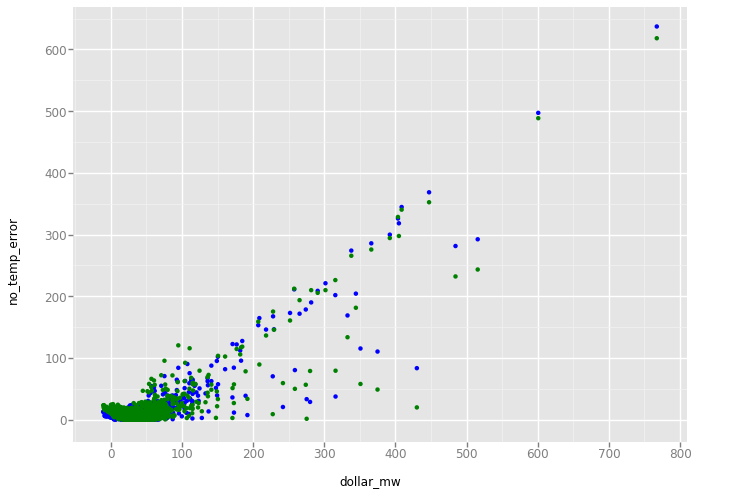

<ggplot: (-9223363284895979909)>

In [10]:
avg_results = y_nt.groupby(level = 'time').mean()
avg_results['time'] = avg_results.index.values

avg_results['temp_error'] = abs(avg_results['temp'] - avg_results['dollar_mw'])
avg_results['no_temp_error'] = abs(avg_results['no_temp'] - avg_results['dollar_mw'])

ggplot(avg_results, aes(x = 'dollar_mw')) + \
    geom_point(aes(y = 'temp_error', color = 'blue')) + \
    geom_point(aes(y = 'no_temp_error', color = 'green'))

Since linear models have to be linear, it makes sense to run them with different (larger) sets of features. For example, adding squared and interaction terms makes more sense. A random forest could achieve this kind of linearity without being given the transformed variables, so there's no need to provide it.

In [11]:
ols = [linear_model.LinearRegression(fit_intercept=False, n_jobs = 3)]

#generate a huge list of different elastic nets
elastic_nets = [linear_model.ElasticNet(alpha= a, l1_ratio = l, warm_start = True)
                for a, l in list(itertools.product(np.linspace(0.5, 1, num = 3), np.linspace(0,1, num = 3)))]

feature_ideas = ['dollar_mw ~ C(node)*(price_last_hr + price_yesterday + price_last_week)+ week + C(day) + solar_MW + wind_MW + latitude + longitude',
                 'dollar_mw ~ C(node)*(price_last_hr + price_yesterday + price_last_week)+ week + C(day) + solar_MW + wind_MW + temp + np.power(temp,2) + np.power(temp,3) + latitude + longitude']

linear_results = run_models(ols + elastic_nets, feature_ideas, df, folds=4, parallel=True)

linear_results.to_pickle('linear_results.p')

A Jupyter Widget

A Jupyter Widget

/home/hobbs/.conda/envs/ipy3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hobbs/.conda/envs/ipy3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hobbs/.conda/envs/ipy3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hobbs/.conda/envs/ipy3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarni

A Jupyter Widget

/home/hobbs/.conda/envs/ipy3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hobbs/.conda/envs/ipy3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hobbs/.conda/envs/ipy3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hobbs/.conda/envs/ipy3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarni

# Nonlinear Model

In [12]:
feature_ideas = ['dollar_mw ~ opr_hr + week + C(day) + solar_MW + wind_MW + temp + latitude + longitude',
                 'dollar_mw ~ opr_hr + week + C(day) + solar_MW + wind_MW + latitude + longitude + price_last_hr + price_yesterday + price_last_week']

rf = ensemble.RandomForestRegressor(n_jobs = 4)
gb = ensemble.GradientBoostingRegressor(max_depth = 10)
models = [rf, gb]

nonlinear_results = run_models(models, feature_ideas, df)
nonlinear_results.to_pickle('nonlinear_results.p')

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

# Graphics

This graphic charts the relationship between temperatures and prices.

In [13]:
normalize = lambda x: (x - np.mean(x)) / np.std(x)

avg_price = pd.DataFrame(df[['dollar_mw', 'temp']].groupby(level = 'time').mean())
avg_price['time'] = avg_price.index.values

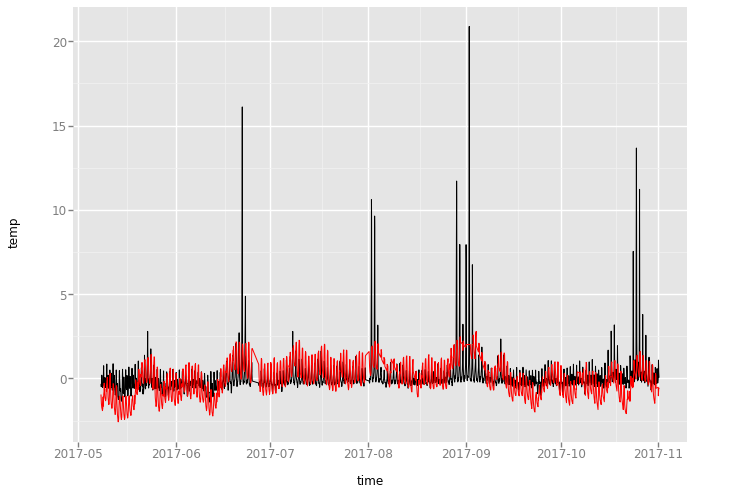

<ggplot: (8751962559373)>

In [14]:
avg_price[['temp', 'dollar_mw']] = avg_price[['temp', 'dollar_mw']].apply(normalize)

ggplot(avg_price, aes(x = 'time')) + \
    geom_line(aes(y = 'dollar_mw')) + \
    geom_line(aes(y = 'temp', color = 'red'))

In [17]:
feature_ideas = ['dollar_mw ~ price_last_hr + price_yesterday + price_last_week']

rf = ensemble.RandomForestRegressor(n_jobs = 4)
gb = ensemble.GradientBoostingRegressor(max_depth = 10)
models = [rf, gb]

nonlinear_results = run_models(models, feature_ideas, df)
nonlinear_results.to_pickle('new_nonlinear_results.p')

A Jupyter Widget

A Jupyter Widget

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/hobbs/.conda/envs/ipy3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/hobbs/.local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/hobbs/.conda/envs/ipy3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [10]:
ols = [linear_model.LinearRegression(fit_intercept=False, n_jobs = 3)]

#generate a huge list of different elastic nets
elastic_nets = [linear_model.ElasticNet(alpha= a, l1_ratio = l, warm_start = True)
                for a, l in list(itertools.product(np.linspace(0.5, 1, num = 3), np.linspace(0,1, num = 3)))]

feature_ideas = ['dollar_mw ~ C(node)*(price_last_hr + price_yesterday + price_last_week)']

linear_results = run_models(ols, feature_ideas, df, folds=4, parallel=True)

linear_results.to_pickle('new_linear_results.p')

linear_results.head()

A Jupyter Widget

A Jupyter Widget

NameError: name 'linear' is not defined

In [11]:
# A single
linear_results.head()

,errors,features,model,score,y_hats
0,"[[1.99289798116e+12, 3.12204843152e+12, 4.5786...",dollar_mw ~ C(node)*(price_last_hr + price_yes...,"LinearRegression(copy_X=True, fit_intercept=Fa...",1.778922e+14,"[[-1.99289798113e+12, -3.12204843147e+12, -4.5..."


In [12]:
import statsmodels.formula.api as smf

model = 'dollar_mw ~ C(node)*(price_last_hr + price_yesterday + price_last_week)'

model = smf.ols(model, data = df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dollar_mw   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     2092.
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        14:58:30   Log-Likelihood:            -1.5747e+06
No. Observations:              354430   AIC:                         3.150e+06
Df Residuals:                  354054   BIC:                         3.154e+06
Df Model:                         375                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       2.6143      0.574      4.556      0.000       1.490       3.739
C(node)[T.ALMDACT1_7_B1]                        3.3346      0.789      4.227      0.000       1.789       4.881
C(node)[T.BAHIA_2_N018]                         0.2611      0.804      0.325      0.745      -1.315       1.837
C(node)[T.BCRK1-2_1_N004]                      -0.0688      0.797     -0.086      0.931      -1.630       1.492
C(node)[T.BELMONT_1_N008]                       0.2851      0.804      0.355      0.723      -1.291       1.861
C(node)[T.BERNARDO_6_N014]                      0.1916      0.816      0.235      0.814      -1.407       1.790
C(node)[T.BIGCRK1_7_N001]                      -0.0702      0.797     -0.088      0.930      -1.631       1.491
C(node)[T.BULLARD_1_N006]                       0.2875      0.816      0.352      0.725      -1.313       1.888
C(node)[T.B_6_N005]                             0.1459      0.774      0.188      0.851      -1.372       1.664
C(node)[T.CALAVE_1_N002]                        0.1725      0.812      0.212      0.832      -1.419       1.764
C(node)[T.CANAL_6_N001]                         0.0236      0.800      0.030      0.976      -1.544       1.591
C(node)[T.CAPAY_6_N001]                        -0.1846      0.809     -0.228      0.820      -1.770       1.401
C(node)[T.CEDRCRK_6_N001]                      -0.4457      0.802     -0.556      0.578      -2.018       1.126
C(node)[T.CENTERS_6_N004]                       0.0071      0.809      0.009      0.993      -1.578       1.592
C(node)[T.CERTTEED_1_N002]                      0.3046      0.821      0.371      0.711      -1.305       1.914
C(node)[T.CITYUKH_1_B1]                         0.3236      0.748      0.433      0.665      -1.142       1.789
C(node)[T.CORRAL_6_N001]                        0.3759      0.783      0.480      0.631      -1.158       1.910
C(node)[T.CRESSEY_1_N003]                       0.0287      0.886      0.032      0.974      -1.708       1.766
C(node)[T.CSCGNRA2_7_N101]                     -0.7188      0.855     -0.841      0.401      -2.395       0.957
C(node)[T.DAVIS_1_N030]                        -0.5386      0.833     -0.647      0.518      -2.170       1.093
C(node)[T.DEEPWATR_1_N101]                     -0.5388      0.833     -0.647      0.518      -2.171       1.094
C(node)[T.DEVERS_1_N057]                       -0.8373      0.851     -0.984      0.325      -2.504       0.830
C(node)[T.DINUBA_6_N005]                        0.2835      0.808      0.351      0.726      -1.300       1.867
C(node)[T.DIXONLD_1_N008]                       0.2056      0.803      0.256      0.798      -1.369       1.780
C(node)[T.DUKMOSS3_7_B2]                        0.0608     

In [15]:
import statsmodels.formula.api as smf

model = 'dollar_mw ~ price_last_hr + price_yesterday + price_last_week'

model = smf.ols(model, data = df.loc['ALAMT4G_7_B1'])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dollar_mw   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     3275.
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        15:03:14   Log-Likelihood:                -18169.
No. Observations:                4163   AIC:                         3.635e+04
Df Residuals:                    4159   BIC:                         3.637e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.6143      0.530      4.928      0.000       1.574       3.654
price_last_hr       0.6360      0.011     57.053      0.000       0.614       0.658
price_yesterday     0.2570      0.011     23.042      0.000       0.235       0.279
price_last_week     0.0411      0.009      4.548      0.000       0.023       0.059
==============================================================================
Omnibus:                     5919.154   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4913188.127
Skew:                           7.925   Prob(JB):                         0.00
Kurtosis:                     170.552   Cond. No.                         147.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
nonlinear_results.iloc[0]['errors'][0]

array([ 2.69608326,  1.85198326,  6.19460068, ...,  1.87388   ,
        2.17351379, -0.2409626 ])

In [ ]:
nonlinear_results.iloc[0]['errors'][0]